## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО "Так закаляем сталь" решил уменьшить потребление электроэнергии на этапе обработки стали. Нужно построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами, которые установлены в крышке ковша.

Из сплава выводится сера (десульфация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют - изменяют её состав, подавая куски сплава из бункера для сыпучих материалов и проволоку через специальный трайб-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (анг. slab - плита).

# Содержание

1. [Первичный анализ данных](#Первичный-анализ-данных)
2. [Предобработка данных](#Предобработка-данных)
3. [План решения задачи](#План-решения-задачи)
4. [Решение задачи](#Решение-задачи)
*    1.[Агрегация признаков](#Агрегация-признаков)
*    2.[Разделение датасета на обучающую и тестовую выборки](#Разделение-датасета-на-обучающую-и-тестовую-выборки)
*    3.[Машинное обучение](#Машинное-обучение)
5. [Вывод](#Вывод)

## Первичный анализ данных

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

Посмотрим на данные, начнём с данных об электродах.

In [2]:
data_arc = pd.read_csv('data_arc.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Мы видим, что в данной таблице помимо ключа, есть четыре столбца: *Начало нагрева дугой*, *Конец нагрева дугой*, которые отвечают за начало и окончание нагрева электродов, и *Активная мощность* и *Реактивная мощность*.

Названия столбцов написаны на русском, да ещё и с пробелами. Для дальнеёшего удобства переименуем столбцы и избавимся от пробелов в названиях.

In [3]:
data_arc.columns

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object')

In [4]:
data_arc.columns = ['key', 'start_heating', 'end_heating', 'active_power', 'reactive_power']

Посмотрим на данные подробнее.

In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   end_heating     14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


В данной таблице мы имеем 14876 объектов, пропуски отсутствуют. 

Проверим временной отрезок с которым нам предстоит работать.

In [6]:
data_arc['start_heating'].min(), data_arc['start_heating'].max()

(Timestamp('2019-05-03 11:02:14'), Timestamp('2019-09-01 04:34:47'))

Перед нами данные с 11 часов 3 мая 2019 года по 4 часа 1 сентября 2019 года, то есть данные за 4 месяца.

Взглянем на описание данных.

In [7]:
data_arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Активная мощность находится в диапазоне от 0.03 до 3.73, а среднее значение мощности равно 0.67.

Реактивная мощность располагается от -715.5 до 2.68, при среднем 0.45. Слишком большое отрицательное значение реактивной мощности вкупе со стандартным отклонением в 5.9 наводят на мысль, что это значение инородно.

Посмотрим на все отрицательные значения реактивной мощности, часты ли они или редки.

In [8]:
data_arc[data_arc['reactive_power'] < 0]

,key,start_heating,end_heating,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Как мы видим, это единичный случай, и это скорее всего ошибка в данных.

Сгруппируем данные по ключу, чтобы понять сколько у нас уникальных ковшей.

In [9]:
data_arc.groupby(by='key').mean()

,active_power,reactive_power
key,,
1,0.975629,0.636648
2,0.763150,0.499528
3,0.505176,0.319815
4,0.802313,0.515074
5,0.836793,0.563161
...,...,...
3237,0.786493,0.565692
3238,0.702176,0.560394
3239,0.583344,0.388952


У нас 3214 уникальных ключей от 1 до 3241, что означает, что у нас есть пропуски в данных.

Теперь посмотрим на данные об объёме подачи сыпучих материалов.

In [10]:
data_bulk = pd.read_csv('data_bulk.csv')

data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Мы видим, что в этой таблице много пропусков, вероятно, что порпуски означают, что дополнительно сыпучие материалы не добавлялись. Взглянем повнимательнее на данные.

In [11]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [12]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Мы видим, что некоторые элементы для легирования используются часто, а какие-то использовались единично. Объём сыпучих элемнтов также разнится от 1 до почти двух тысяч.

Главное, что у нас различается количество ковшей в сравнении с таблицей **data_arc**.

Теперь взглянем на данные о времени подачи сыпучих материалов.

In [13]:
data_bulk_time = pd.read_csv('data_bulk_time.csv')

data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [14]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Мы видим, что данные о времени отражают время подачи сыпучих материалов из таблицы **data_bulk**, там, где отсутствуют данные о времени, сыпучие материалы в ковш не подавались.

Посмотрим на данные о продувке сплава газом.

In [15]:
data_gas = pd.read_csv('data_gas.csv')

data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Здесь также переименуем столбцы.

In [16]:
data_gas.columns = ['key', 'gas']

In [17]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Мы можнм заметить, что количество ковшей в этой таблице снова отличается, от количества ковшей в предыдущих таблицах.

Рассмотрим подробнее эту таблицу.

In [18]:
data_gas.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


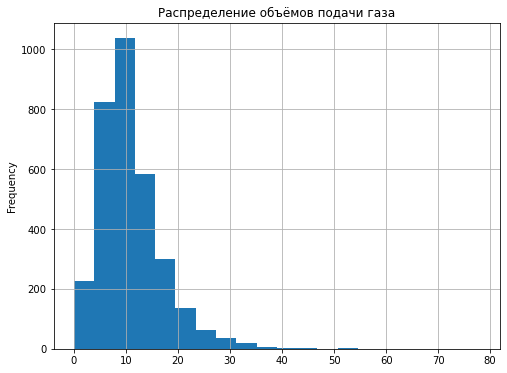

In [19]:
data_gas['gas'].plot(kind='hist', grid=True, bins=20, figsize=(8,6), title='Распределение объёмов подачи газа');

Газ подаётся в разных объёмах от минимального в почти 0 до максимума в 78, среднее значение же составляет 10-11. Да и чаще всего необходим именно такой объём инертных газов.

Посмотрим на таблицу результатов измерения температуры, нашего целевого признака.

In [20]:
data_temp = pd.read_csv('data_temp.csv', parse_dates=['Время замера'])

In [21]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Изменим названия столбцов.

In [22]:
data_temp.columns

Index(['key', 'Время замера', 'Температура'], dtype='object')

In [23]:
data_temp.columns = ['key', 'measure_time', 'temperature']

В каждом ковше температура измеряется несколько раз в процессе производства стали, поэтому с одинаковым ключом в таблице присутствует несколько данных.

In [24]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   measure_time  15907 non-null  datetime64[ns]
 2   temperature   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


По информации о таблице видно, что в столбце с температурой имеются пропуски, вероятно температура не измерялась, или данные просто потерялись.

In [25]:
data_temp.describe()

,key,temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


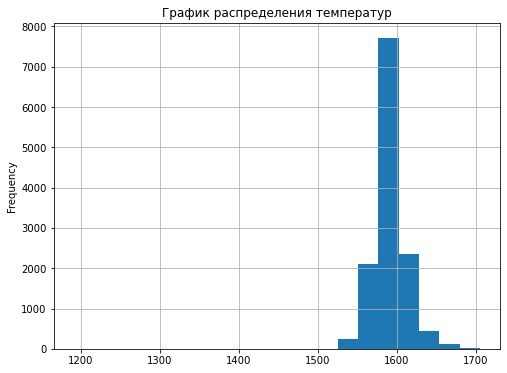

In [26]:
data_temp['temperature'].plot(kind='hist', grid=True, bins=20, figsize=(8,6), title='График распределения температур');

Температура в представленных измерениях колеблется от 1191 до 1705 градусов. А средняя температура практически совпадает с медианной и равна 1591 градусов.

Сгруппируем данные по ключу и посмотрим сколько ковшей задействовано при измерении температуры.

In [27]:
data_temp.groupby(by='key').mean()

,temperature
key,
1,1601.400000
2,1593.500000
3,1597.800000
4,1616.333333
5,1589.000000
...,...
3237,1569.000000
3238,1584.000000
3239,1598.000000


Снова мы видим, что в таблице также имеются порпуски и представлены измерения не по всем ковшам со сплавом.

Теперь взглянем на данные об объёме проволочных материалов.

In [28]:
data_wire = pd.read_csv('data_wire.csv')

data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Также как и с подачей сыпучих материалов данные о подаче проволочных материалов имеют пропуски в таблице, которые говорят о том, что данные материалы в ковш не вводились.

In [30]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Поадача различных проволочных материалов также добаваляется в разных объёмах от 0.03 до 385.

Данные о времени введения проволочных материалов.

In [31]:
data_wire_time = pd.read_csv('data_wire_time.csv')

data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


По аналогии с добавлением сыпучих материалов эта таблица характеризует время добавления проволочных материалов из таблицы **data_wire**. Пропуски говорят, что проволочные материалы не вводились, поэтому данных о времени по ним нет.

## Предобработка данных

Поскольку в данной задаче мы имеем дело не с временными рядами, то в дальнейшем данные о времени обработки стали нам не понадобятся, от них можно отказаться и не производить предобработку.

Начнём с данных об электродах. В ходе анализа мы выяснили, что у нас имеется отрицательное значение *реактивной мощности*, которое скорее всего является ошибкой, которую нужно исправить.

In [33]:
data_arc[data_arc['reactive_power'] < 0]

,key,start_heating,end_heating,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Мы видим, что отрицательный результат единичный и находится в данных о ковше с номером 2116. Посмотрим на остальные значения мощности в этом ковше.

In [34]:
data_2116 = data_arc[data_arc['key'] == 2116]
data_2116

,key,start_heating,end_heating,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Реактивная мощность по данному ключу в остальных случаях находится в диапазоне от 0.2 до 0.4, поэтому значение в -715 выглядит артефатом. Заменим его средним значением по данному ковшу.

In [35]:
data_2116_mean = data_2116[data_2116['reactive_power'] > 0]['reactive_power'].mean()

In [36]:
data_arc.loc[data_arc['reactive_power'] < 0, 'reactive_power'] = data_2116_mean

In [37]:
data_arc[data_arc['reactive_power'] < 0]

,key,start_heating,end_heating,active_power,reactive_power


Данных меньше 0 в столбце *Реактивная мощность* не осталось.

Добавим в таблицу время нагрева электрода в секундах.

In [38]:
data_arc['time_heating_sec'] = (data_arc['end_heating']-data_arc['start_heating'])/np.timedelta64(1,'s')

In [39]:
data_arc['time_heating_sec'].describe()

count    14876.000000
mean       171.670946
std         98.186803
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: time_heating_sec, dtype: float64

Время нагрева различается от 11 до 907 секунд, при среднем значении в 172 секунды. Квантили дают понять, что каждый нагрев происходит в основном от 107 до 214 секунд.

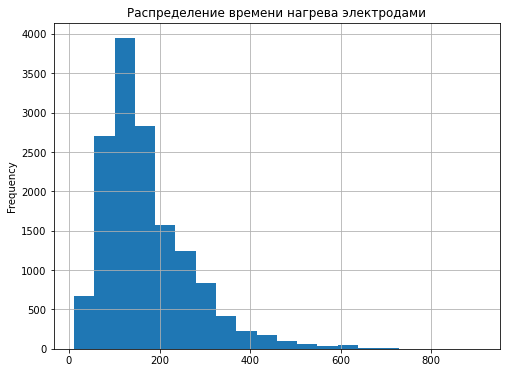

In [40]:
data_arc['time_heating_sec'].plot(kind='hist', grid=True, bins=20, figsize=(8,6),
                                  title='Распределение времени нагрева электродами');

Наиболее часто встречающееся время нагрева от 100 до 150 секунд.

Также добавим информацию о полной мощности, которая вычисляется как корень из суммы квадратов активной и реактивной мощностей.

In [41]:
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5

In [42]:
data_arc['full_power'].describe()

count    14876.000000
mean         0.838750
std          0.509840
min          0.036664
25%          0.495346
50%          0.694922
75%          1.066649
max          4.592152
Name: full_power, dtype: float64

Полная затраченная мощность вырьируется от 0.04 до 4.6, в среднем же тратится около 0.84 мщности.

Избавимся от пропусков в данных об объёме подачи сыпучих материалов.

In [43]:
data_bulk = data_bulk.fillna(0)
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Также избавимся от пропусков в данных об объёме проволочных материалов.

In [44]:
data_wire = data_wire.fillna(0)
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Теперь посмотрим на пропуски в таблице с температурой.

In [45]:
data_temp[data_temp['temperature'].isnull()]

,key,measure_time,temperature
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Более 2900 строк, где отсутствует значение температуры. Поскольку мы не сможем чем-то заменить пропуски, придётся удалить эти строки.

In [46]:
data_temp = data_temp.dropna()
data_temp

,key,measure_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15878,3237,2019-08-31 22:44:04,1569.0
15883,3238,2019-08-31 23:30:31,1584.0
15886,3239,2019-09-01 01:31:47,1598.0
15894,3240,2019-09-01 02:39:01,1617.0


У нас осталось чуть более 13 тысяч значений после удаления пропусков.

Посмотрим на количество измерений в каждом ковше после удаления пропусков.

In [47]:
data_temp_grouped = data_temp.groupby(by='key').count()
data_temp_grouped

,measure_time,temperature
key,,
1,5,5
2,6,6
3,5,5
4,3,3
5,2,2
...,...,...
3237,1,1
3238,1,1
3239,1,1


Как мы видим, в каждом ковше есть разное количество измерений, есть и 6, а есть и одно измерение. Поскольку наш целевой признак это конечная темепература в ковше, а начальную темепературу можно использовать как признак, то ковши, в которых есть лишь одно измерение нам не подходят, а значит и от них можно избавиться.

In [48]:
temp = data_temp_grouped[data_temp_grouped['temperature'] == 1]

In [49]:
data_temp = data_temp.query('key not in @temp.index')
data_temp

,key,measure_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


Таким образом у нас осталось 12265 измерений температуры по всем ковшам, в которых проводились измерения 2 и более раз.

## План решения задачи

* 1. Для начала нам нужно агрегировать все признаки в один датасет. Группируем все признаки, кроме времени добавления примесей, по ключу. Поскольу в каждой из таблиц некоторые ключи могут отсутствовать, то после объединения нужно обработать порпуски или удалить эти строки.


* 2. Разделить полученный датасет на признаки и целевой признак, а также разделить данные на обучающую и тестовую выборки. В качестве целевого признака выделим конечную температуру в ковшах. В качестве обучающей выборки возьмём 75% от всего датасета.


* 3. Подобрать модель машинного обучения и её параметры. Так как наш целевой признак температура, то модель будем выбирать регрессионную, а в качестве метрики качества будем использовать MAE - среднюю абсолютную ошибку. Цель - достичь на тестовой выборке значения MAE = 6.

## Решение задачи

### Агрегация признаков

Прежде чем собрать все данные в один датасет выделим из таблицы **data_temp** начальную температуру как признак и конечную темепературу, которую будем использовать в качестве целевого признака. Для начала сгруппируем табицу по ключу и выделим время начального замера температуры и время конечного.

In [50]:
first_temp = data_temp.groupby(by='key')['measure_time'].min()
first_temp.head()

key
1   2019-05-03 11:16:18
2   2019-05-03 11:37:27
3   2019-05-03 12:13:17
4   2019-05-03 12:52:57
5   2019-05-03 13:23:19
Name: measure_time, dtype: datetime64[ns]

In [51]:
final_temp = data_temp.groupby(by='key')['measure_time'].max()
final_temp.head()

key
1   2019-05-03 11:30:39
2   2019-05-03 11:59:12
3   2019-05-03 12:34:57
4   2019-05-03 12:59:25
5   2019-05-03 13:36:01
Name: measure_time, dtype: datetime64[ns]

Теперь с помощью запросов разделим датасет на две таблицы, в одной сохраним данные относящиеся к первому замеру, в другой - к фмнальному.

In [52]:
data_first_temp = data_temp.query('measure_time in @first_temp')
data_first_temp.head()

,key,measure_time,temperature
0,1,2019-05-03 11:16:18,1571.0
5,2,2019-05-03 11:37:27,1581.0
11,3,2019-05-03 12:13:17,1596.0
16,4,2019-05-03 12:52:57,1601.0
19,5,2019-05-03 13:23:19,1576.0


In [53]:
data_final_temp = data_temp.query('measure_time in @final_temp')
data_final_temp.head()

,key,measure_time,temperature
4,1,2019-05-03 11:30:39,1613.0
10,2,2019-05-03 11:59:12,1602.0
15,3,2019-05-03 12:34:57,1599.0
18,4,2019-05-03 12:59:25,1625.0
20,5,2019-05-03 13:36:01,1602.0


Таблицу **data_arc** также подготовим к слиянию, с группируем все данные в ней по ключу (или номеру ковша) и просуммируем признаки.

In [54]:
data_arc_grouped = data_arc.groupby(by='key').agg('sum')
data_arc_grouped.head()

,active_power,reactive_power,time_heating_sec,full_power
key,,,,
1,4.878147,3.183241,1098.0,5.826395
2,3.052598,1.998112,811.0,3.649216
3,2.525882,1.599076,655.0,2.989534
4,3.209250,2.060298,741.0,3.814962
5,3.347173,2.252643,869.0,4.035758


Теперь, когда все таблицы приведены к единому виду, мы можем объединить их в один большой датасет. Используем для этого функцию *merge*, а объединять будем по ключу. Поскольку для нас важным является признак температуры, будем использовать его, как основной при объединении.

In [55]:
data_merged = data_first_temp.merge(data_arc_grouped, how='left', on='key').merge(data_bulk, how='left', on='key')\
                                                                           .merge(data_gas, how='left', on='key')\
                                                                           .merge(data_wire, how='left', on='key')\
                                                                           .merge(data_final_temp, how='left', on='key')
data_merged.head()

,key,measure_time_x,temperature_x,active_power,reactive_power,time_heating_sec,full_power,Bulk 1,Bulk 2,Bulk 3,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,measure_time_y,temperature_y
0,1,2019-05-03 11:16:18,1571.0,4.878147,3.183241,1098.0,5.826395,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,3.052598,1.998112,811.0,3.649216,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2.525882,1.599076,655.0,2.989534,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,3.209250,2.060298,741.0,3.814962,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,3.347173,2.252643,869.0,4.035758,0.0,0.0,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:36:01,1602.0


In [56]:
data_merged.shape

(2475, 34)

Итак, мы получили датасет, в котором 2475 объектов и 34 признака.

Добавим ещё один признак - время между первым и последним замером в секундах.

In [57]:
data_merged['time_period'] = (data_merged['measure_time_y']-data_merged['measure_time_x'])/np.timedelta64(1,'s')
data_merged.head()

,key,measure_time_x,temperature_x,active_power,reactive_power,time_heating_sec,full_power,Bulk 1,Bulk 2,Bulk 3,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,measure_time_y,temperature_y,time_period
0,1,2019-05-03 11:16:18,1571.0,4.878147,3.183241,1098.0,5.826395,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:30:39,1613.0,861.0
1,2,2019-05-03 11:37:27,1581.0,3.052598,1.998112,811.0,3.649216,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:59:12,1602.0,1305.0
2,3,2019-05-03 12:13:17,1596.0,2.525882,1.599076,655.0,2.989534,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:34:57,1599.0,1300.0
3,4,2019-05-03 12:52:57,1601.0,3.209250,2.060298,741.0,3.814962,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:59:25,1625.0,388.0
4,5,2019-05-03 13:23:19,1576.0,3.347173,2.252643,869.0,4.035758,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:36:01,1602.0,762.0


Так как у нас в таблицах было разное количество ковшей, где-то больше, где-то меньше, при агрегации признаков мы могли получить пропуски в данных. Проверим это.

In [58]:
data_merged.isna().sum()

key                   0
measure_time_x        0
temperature_x         0
active_power          0
reactive_power        0
time_heating_sec      0
full_power            0
Bulk 1               68
Bulk 2               68
Bulk 3               68
Bulk 4               68
Bulk 5               68
Bulk 6               68
Bulk 7               68
Bulk 8               68
Bulk 9               68
Bulk 10              68
Bulk 11              68
Bulk 12              68
Bulk 13              68
Bulk 14              68
Bulk 15              68
gas                   2
Wire 1              103
Wire 2              103
Wire 3              103
Wire 4              103
Wire 5              103
Wire 6              103
Wire 7              103
Wire 8              103
Wire 9              103
measure_time_y        0
temperature_y         0
time_period           0
dtype: int64

Как мы видим, пропуски у нас пришли вместе с таблицами **data_bulk**, **data_gas** и **data_wire**. Мы не можем заменить эти пропуски в данных какими-нибудь значениями, потому что не знаем, чем они вызваны. Они могут быть утрачены при составлении таблиц, а может добавление этих веществ не производилось в принципе. Удалим все объекты с пропусками, тем более их не так много.

Также удалим признаки с временем замера температур, они нам уже не понадобятся.

In [59]:
data_merged_drop = data_merged.dropna().drop(['measure_time_x', 'measure_time_y'], axis=1).copy()
data_merged_drop.head()

,key,temperature_x,active_power,reactive_power,time_heating_sec,full_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,temperature_y,time_period
0,1,1571.0,4.878147,3.183241,1098.0,5.826395,0.0,0.0,0.0,43.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1613.0,861.0
1,2,1581.0,3.052598,1.998112,811.0,3.649216,0.0,0.0,0.0,73.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1602.0,1305.0
2,3,1596.0,2.525882,1.599076,655.0,2.989534,0.0,0.0,0.0,34.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1599.0,1300.0
3,4,1601.0,3.209250,2.060298,741.0,3.814962,0.0,0.0,0.0,81.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1625.0,388.0
4,5,1576.0,3.347173,2.252643,869.0,4.035758,0.0,0.0,0.0,78.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1602.0,762.0


In [60]:
data_merged_drop.shape

(2329, 33)

Итак, у нас осталось 2329 признаков с которыми мы и будем работать. Но для начала проверим корреляцию все признаки.

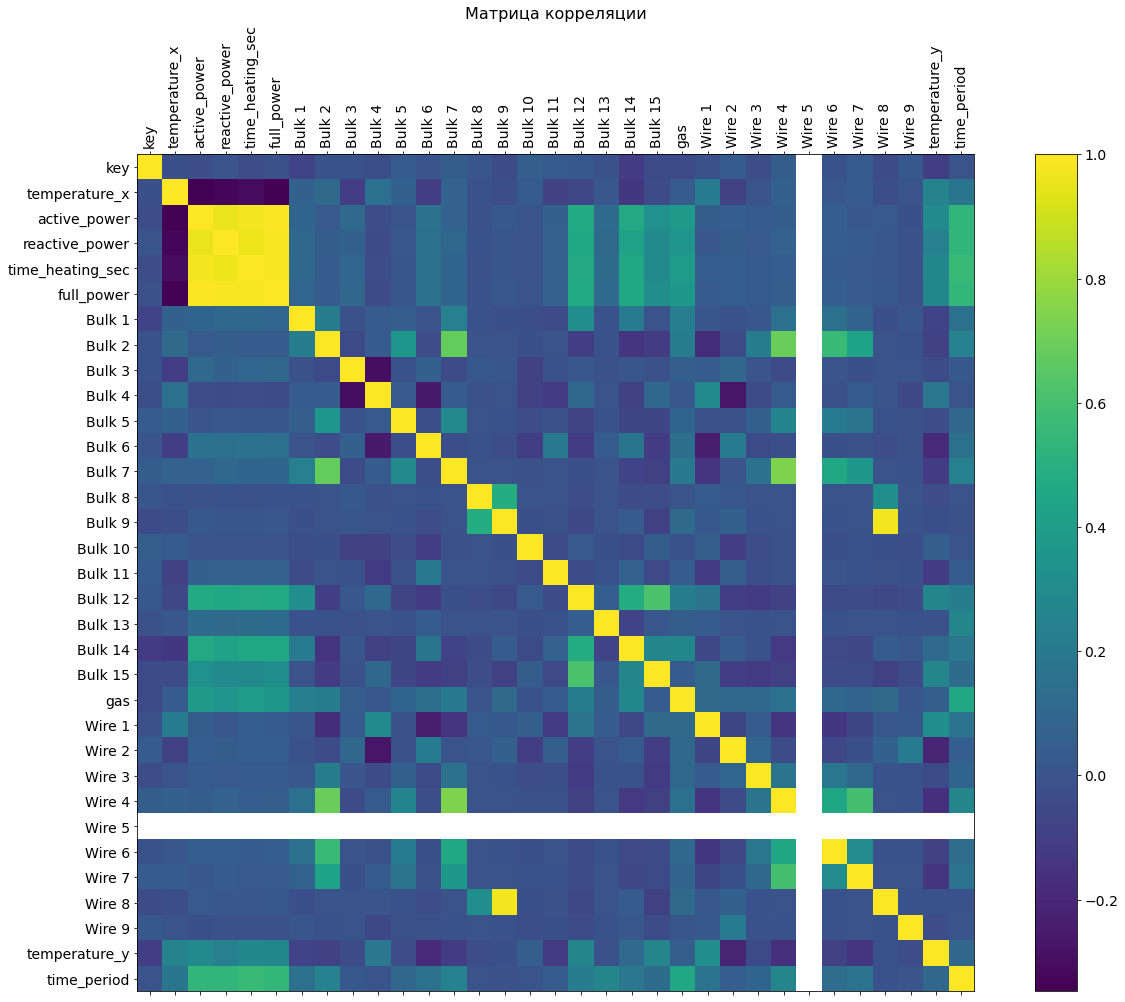

In [61]:
f = plt.figure(figsize=(22, 15))
plt.matshow(data_merged_drop.corr(), fignum=f.number)
plt.xticks(range(data_merged_drop.shape[1]), data_merged_drop.columns, fontsize=14, rotation=90)
plt.yticks(range(data_merged_drop.shape[1]), data_merged_drop.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Матрица корреляции', fontsize=16);

Мы видим, что *active_power*, *reactive_power*, *time_heating_sec* и *full_power* очень сильно коррелируют между собой, также высокая корреляция между *Wire 8* и *Bulk 9*. Чтобы избежать мультиколлинеарности, уберём из датасета часть коррелирующих признаков, оставим *Bulk 9*, *time_heating_sec* и *full_power*.

In [62]:
data_merged_drop = data_merged_drop.drop(['Wire 8', 'active_power', 'reactive_power'], axis=1).copy()

### Разделение датасета на обучающую и тестовую выборки

Первым делом выделим признаки для обучения *features* и целевой признак *target*.

In [63]:
target = data_merged_drop['temperature_y']
features = data_merged_drop.drop(['key', 'temperature_y'], axis=1)

Затем разобъём данные на обучающую и тестовую выборки, выделив для теста 25% от всего датасета.

In [64]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42)

Посмотрим на резмеры получившихся признаков.

In [65]:
features_train.shape, features_test.shape

((1746, 28), (583, 28))

Обучаться мы будем на 1746 объектах, а проверять на 583 объектах.

Поскольку в признаках мы имеем дело с большим разбросом данных, масштабируем их используя *StandardScaler*. Обучим его на обучающей выборке, а затем применим к обучающей и тестовой.

In [66]:
features_train.columns

Index(['temperature_x', 'time_heating_sec', 'full_power', 'Bulk 1', 'Bulk 2',
       'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9',
       'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'gas',
       'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7',
       'Wire 9', 'time_period'],
      dtype='object')

In [67]:
numeric = ['temperature_x', 'time_heating_sec', 'full_power', 'Bulk 1', 'Bulk 2',
       'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9',
       'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'gas',
       'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7',
       'Wire 9', 'time_period']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [68]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Взглянем на обновлённые признаки.

In [69]:
features_train.head()

,temperature_x,time_heating_sec,full_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 9,time_period
1678,-2.008810,1.293905,1.476629,-0.276616,-0.058294,0.000146,-0.6292,-0.116798,-0.407858,-0.050432,...,0.116983,0.294311,0.834608,-0.110831,-0.054872,0.0,-0.103888,-0.025026,-0.096613,-0.087855
1857,1.004053,-0.530853,-0.725307,-0.276616,-0.058294,0.134522,-0.6292,-0.116798,-0.407858,-0.050432,...,0.401819,0.149466,-0.530098,-0.110831,-0.054872,0.0,-0.103888,-0.025026,-0.096613,0.154186
2414,0.780878,0.474804,0.416787,-0.276616,-0.058294,-0.631419,-0.6292,-0.116798,1.737030,-0.050432,...,2.126575,-0.600633,-0.530098,-0.110831,-0.054872,0.0,-0.103888,-0.025026,-0.096613,1.434518
1769,-0.446584,-0.548343,-0.509484,-0.276616,-0.058294,1.021400,-0.6292,-0.116798,-0.407858,-0.050432,...,0.212877,1.737234,0.930393,-0.110831,-0.054872,0.0,-0.103888,-0.025026,-0.096613,-0.211515
2037,0.520507,-0.898137,-0.976447,-0.276616,-0.058294,1.021400,-0.6292,-0.116798,-0.407858,-0.050432,...,-0.476765,-0.653264,-0.530098,-0.110831,-0.054872,0.0,-0.103888,-0.025026,-0.096613,-0.637539


Мы видим, что разброс значений теперь небольшой, хоть и в некоторых случаях отрицательный.

### Машинное обучение

Для нашей задачи регрессии возьмём для начала самую простую модель **линейной регрессии**. Обучим её на тренировочных данных, а затем предскажем температуру на тестовой выборке. Точность предсказаний проверим с помощью MAE.

In [70]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predicted_lr = model_lr.predict(features_test)
mean_absolute_error(target_test, predicted_lr)

6.541659119994656

Обученная на наших данных модель **линейной регрессии** на тестовой выборке дала точность в 6.54 MAE, что является очень хорошим результатом, но не идеальным.

Проверим эту модель на адекватность, создадим константную модель, которая будет предсказывать всегда среднее значение темепературы обучающей выборки и посчитаем MAE.

In [71]:
const = pd.Series([target_train.mean()]*len(target_test))

In [72]:
mean_absolute_error(target_test, const)

8.126939498073526

Константная модель дала точнось в 8.12 MAE, а значит наша модель **линейной регрессии** адекватна.

Есть надежда, что мы сможем улучшить результат, есть воспользуемся бустинговой моделью **CatBoost**.

Возьмём базовую модель **CatBoostRegressor**, а в качестве гиперпараметров укажем только *learning_rate* равный 0.01 и *loss_function* - MAE.

In [73]:
model_CBR = CatBoostRegressor(random_state=42, verbose=100, learning_rate=0.01, loss_function='MAE')
model_CBR.fit(features_train, target_train, eval_set=(features_test, target_test))
predicted_CBR = model_CBR.predict(features_test)
mean_absolute_error(target_test, predicted_CBR)

0:	learn: 8.0115454	test: 8.0742014	best: 8.0742014 (0)	total: 239ms	remaining: 3m 58s
100:	learn: 6.6274990	test: 6.9929282	best: 6.9929282 (100)	total: 544ms	remaining: 4.84s
200:	learn: 5.9750116	test: 6.5493945	best: 6.5493945 (200)	total: 792ms	remaining: 3.15s
300:	learn: 5.5557900	test: 6.2850146	best: 6.2850146 (300)	total: 1.04s	remaining: 2.42s
400:	learn: 5.2796867	test: 6.1492655	best: 6.1492655 (400)	total: 1.32s	remaining: 1.97s
500:	learn: 5.0653743	test: 6.0762337	best: 6.0762337 (500)	total: 1.62s	remaining: 1.61s
600:	learn: 4.8873307	test: 6.0092668	best: 6.0088259 (599)	total: 1.86s	remaining: 1.24s
700:	learn: 4.7374530	test: 5.9744846	best: 5.9744846 (700)	total: 2.11s	remaining: 898ms
800:	learn: 4.5913143	test: 5.9302714	best: 5.9302714 (800)	total: 2.36s	remaining: 586ms
900:	learn: 4.4435665	test: 5.8907513	best: 5.8907513 (900)	total: 2.61s	remaining: 287ms
999:	learn: 4.3099326	test: 5.8624951	best: 5.8624951 (999)	total: 2.85s	remaining: 0us

bestTest = 5.8

5.862496135516596

Бустинговая модель отлично справилась с поставленной задачей. Без настраивания гиперпараметров нам удалось достичь результата точность нашей модели в 5.86 MAE.

Взглянем на разброс остатков.

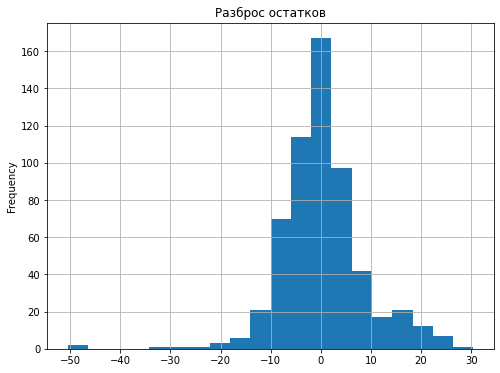

In [74]:
(target_test-predicted_CBR).plot(kind='hist', grid=True, bins=20, figsize=(8,6),
                                 title='Разброс остатков');

В целом, большая часть остатков находится в диапазоне от -10 до 10 градусов, а чаще встречается разница между истинными и предсказанными значениями около нуля. Это говорит о том, что наша модель в большинстве случаев довольно точно предсказывает конечную температуру. Разброс же в разнице ответов составляет 80 градусов от -50 до 30.

Посмотрим на 10 принаков, которые были наиболее важны при обучении этой модели.

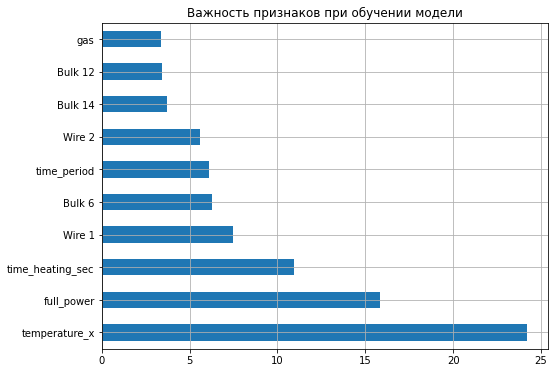

In [75]:
pd.Series(model_CBR.feature_importances_, index=features_train.columns).nlargest(10)\
                                                                       .plot(kind='barh', grid=True, figsize=(8,6), 
                                                                             title='Важность признаков при обучении модели');

Как можно заметить, самым выжным признаком модель посчиатала начальную температуру -  чуть менее 25%, т.е. модель чаще выбирала этот признак как решающий. Да, начальная и конечная температура похожи, поэтому такое не удививтельно. Проверим какая зависимость между этими признаками.

Вторым по важности является активная мощность - более 15%, третьим - время нагрева электродами - более 10%. Остальные признаки набрали менее 7%.

Проверим корреляцию температур.

In [76]:
data_merged_drop['temperature_x'].corr(data_merged_drop['temperature_y'])

0.25244348376489756

Как видим, зависимость между начальной и финальной температурой очень слабая.

## Вывод

1. Мы изучили данные о производстве стали и провели исследовательский анализ. Выяснили, что некоторые данные отсутствуют, а также добавили новые признаки, такие как **time_heating_sec**, **full_power** и **time_period**, которые в дальнейшем использовались для обучения модели.


2. Мы подготовили план решения задачи.


3. На этапе решения задачи по предсказанию температур мы выполнили следующее:

    * Провели агрегацию всех признаков в один большой датасет, объединив всё по значению ключа(ковшей);
    * Подготовили данные для машинного обучения: разбили выборку на обучающую и тестовую, выделили признаки для обучения и целевой признак, а также провели масштаирование признаков;
    * На этапе машинного обучения мы проверили для начала модель **линейной регрессии** с помощью неё достигли точности предсказаний в 6.54 MAE, а также проверили эту модель на адекватность. Далее, используя модель **CatBoostRegressor** мы смогли достичь значения MAE равного 5.86, что удовлетворяет решению нашей задачи.

Поскольку перед нами стояла цель понять как сэкономить на производстве стали, то можно сказать, что для экономии ресурсов стоит обратить внимание на начальную температуру, как самый важный признак при обучении. Управляя начальной температурой можно замено сэкономить. Также стоит обратить внимание и на полную мощность, которая берётся из активной и реактивной мощностей. Зная, какой мощности будет достаточно для нагрева электродами, можно также экономить ресурсы. Немаловажным фактором будет и время нагрева. А вообще стоит рассматривать эти два фактора в совокупности, так как всё же зависят друг от друга.

Нам удалось выполнить все поставленные цели нашего плана.

Основные трудности возникли с достижением необходимой точности предсказания нашей модели. Поскольку исходных данных не хватало для достижения поставленной задачи, пришлось дополнительно создать новые признаки на основе существующих. В связи с этим также пришлось дополнительно проверять нет ли высокой корреляции между всем признаками, чтобы в дальнейшем избежать мультиколлинеарности.

Из ключевых моментов отмечу предобработку данных. Зачастую хорошая предобработка пропусков и артефактов может решить половину проблем. Также важным моментом является поиск новых признаков, которые могут сыграть важную роль в обучении модели. Не последнюю роль в достижении цели сыграл и выбор подходящей модели. 

Так, выбрав **CatBoostRegressor** удалось достичь требуемого качества модели с MAE равным 5.86. Предыдущая выбранная модель линейной регрессии дала качество заметно выше 6 MAE.